## Импорты

In [188]:
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

from scipy.stats import chi2, chi2_contingency
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.api import CompareMeans, DescrStatsW
from statsmodels.stats.proportion import proportion_confint

from IPython.display import clear_output

In [19]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (14, 8)

## Проверка однородности

**Данные о юзерах из эксперимента**

In [20]:
group_info_before = pd.read_csv('group_info_before_exp.csv')
print(group_info_before.shape)
group_info_before.sample(5)

(761546, 5)


,user_id,experiment_group,UserType,user_revenue,exposed_items
239782,131243500015,60_discount,Company,NaN,1
36777,364772785,30_discount,Private,NaN,3
482795,438439000180,30_discount,Private,NaN,6
37801,364952931,30_discount,Company,60.0,38
411470,358323500025,60_discount,Private,NaN,5


**Количество людей в группах**

In [21]:
sellers_split = group_info_before.groupby(['experiment_group', 'UserType'])['user_id'].count()
sellers_split = pd.DataFrame(
    data=sellers_split.values.reshape(3, 3).T,
    columns=list(map(lambda x: x[0], sellers_split.index[::3])),
    index=list(map(lambda x: x[1], sellers_split.index[:3]))
)
sum_sellers = pd.Series(sellers_split.sum(), name='Total')
sellers_split = pd.concat((sellers_split, pd.DataFrame(sum_sellers).T))
sellers_split

,30_discount,60_discount,no_discount
Company,19521,19365,19812
Private,230557,230484,232155
Shop,3166,3212,3274
Total,253244,253061,255241


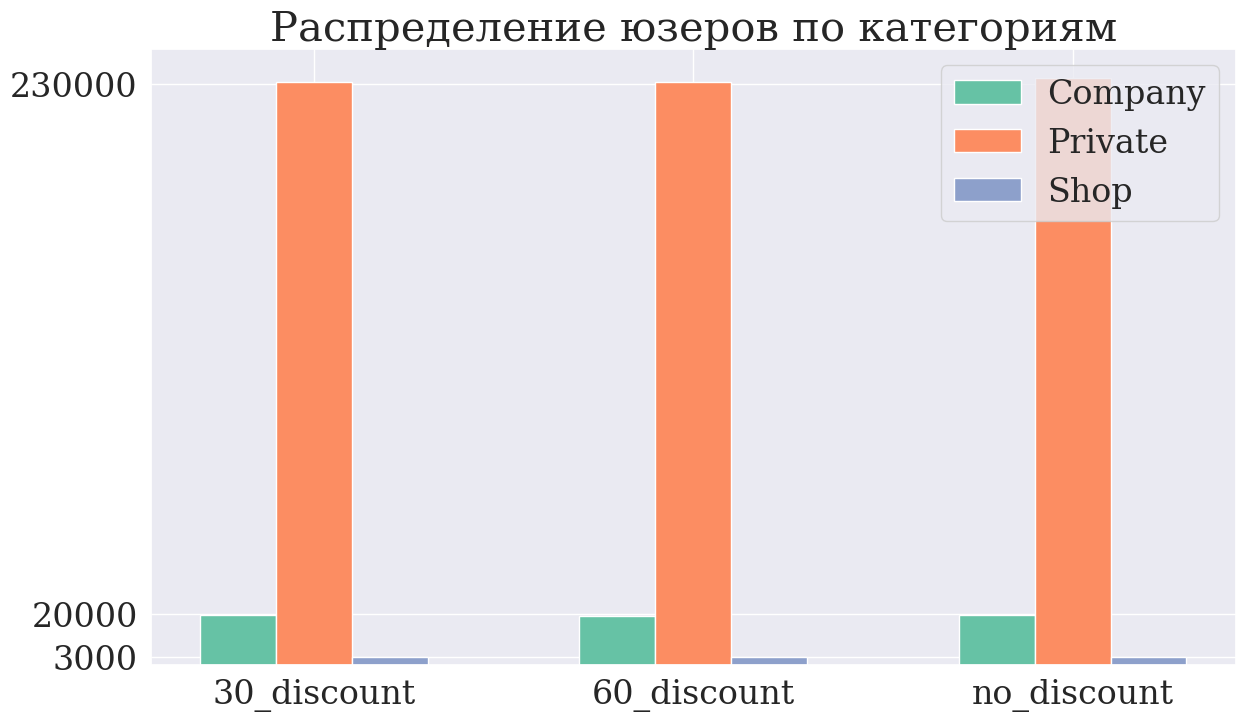

In [22]:
import datetime
from matplotlib.dates import date2num


x = [
    datetime.datetime(2011, 1, 4, 0, 0),
    datetime.datetime(2011, 1, 5, 0, 0),
    datetime.datetime(2011, 1, 6, 0, 0)
]
x = date2num(x)

company = sellers_split.iloc[0]
private = sellers_split.iloc[1]
shop = sellers_split.iloc[2]

plt.bar(x-0.2, company, width=0.2, align='center', label='Company')
plt.bar(x, private, width=0.2, align='center', label='Private')
plt.bar(x+0.2, shop, width=0.2, align='center', label='Shop')

plt.title('Распределение юзеров по категориям')
plt.xticks(x, ['30_discount', '60_discount', 'no_discount'])
plt.yticks([3000, 20000, 230000])
plt.legend()
plt.show()

Смотрим на хи-квадрат

In [23]:
stat, pval, dof, _ = chi2_contingency(sellers_split.T.values[:, :-1])
print(f'{pval = }')

pval = 0.5118275546606365


Всё норм

**Число проданных товаров по группам**

In [24]:
items_split = group_info_before.groupby(['experiment_group', 'UserType'])['exposed_items'].sum()
items_split = pd.DataFrame(
    data=items_split.values.reshape(3, 3).T,
    columns=list(map(lambda x: x[0], items_split.index[::3])),
    index=list(map(lambda x: x[1], items_split.index[:3]))
)
sum_items = pd.Series(items_split.sum(), name='Total')
items_split = pd.concat((items_split, pd.DataFrame(sum_items).T))
items_split

,30_discount,60_discount,no_discount
Company,246952,249697,251486
Private,999746,1006081,1001669
Shop,56257,58657,50259
Total,1302955,1314435,1303414


In [25]:
stat, pval, dof, _ = chi2_contingency(items_split.T.values[:, :-1])
print(f'{pval = }')

pval = 2.0082513989977776e-145


**Вывод:**
Косячок вышел: по проданным товарам группы неоднородны!

**Cтоимость проданных товаров по группам**

In [105]:
group_info_before.groupby(['experiment_group'])['user_revenue'].describe(percentiles=[.25, .75, .99])

,count,mean,std,min,25%,50%,75%,99%,max
experiment_group,,,,,,,,,
30_discount,54616.0,262.539544,1193.927070,17.0,40.076923,83.769231,205.461538,2620.707692,72051.679231
60_discount,54645.0,267.217429,1945.945431,17.0,40.076923,82.923077,202.153846,2683.227692,274108.615385
no_discount,55268.0,257.212849,1143.726683,17.0,40.076923,84.538462,206.846154,2705.058462,103058.668462


In [27]:
group_info_before.groupby(['experiment_group', 'UserType'])['user_revenue'].describe()

count         mean          std        min   
experiment_group UserType                                                 
30_discount      Company    5618.0   360.507589  1444.881972  17.000000  \
                 Private   47420.0   229.320504   934.651399  17.000000   
                 Shop       1578.0   912.008753  3895.369352  17.366154   
60_discount      Company    5714.0   399.062556  1840.408341  17.000000   
                 Private   47344.0   224.325906  1408.078819  17.000000   
                 Shop       1587.0  1072.065069  7636.498978  18.528462   
no_discount      Company    5744.0   392.979021  1665.409058  17.000000   
                 Private   47876.0   221.447909   767.193433  17.000000   
                 Shop       1648.0   823.014666  4085.709484  17.770769   

                                 25%         50%         75%            max  
experiment_group UserType                                                    
30_discount      Company   50.211538  119.769231  298.250000   48831.538462  
                 Private   38.538462   79.846154  189.230769   71510.087692  
                 Shop      68.615385  189.500000  528.846154   72051.679231  
60_discount      Company   50.769231  114.153846  287.538462   61566.853846  
                 Private   39.461538   79.384615  187.307692  274108.615385  
                 Shop      68.615385  178.830769  537.627308  235445.110769  
no_discount      Company   49.230769  118.038462  314.538462   96114.400000  
                 Private   38.846154   80.000000  191.000000   69335.900769  
                 Shop      66.923077  189.500000  509.653846  103058.668462

In [28]:
revenue_split = group_info_before.groupby(['experiment_group', 'UserType'])['user_revenue'].mean()
revenue_split = pd.DataFrame(
    data=revenue_split.values.reshape(3, 3).T,
    columns=list(map(lambda x: x[0], revenue_split.index[::3])),
    index=list(map(lambda x: x[1], revenue_split.index[:3]))
)
revenue_split

,30_discount,60_discount,no_discount
Company,360.507589,399.062556,392.979021
Private,229.320504,224.325906,221.447909
Shop,912.008753,1072.065069,823.014666


Предварительное сравнение средних показывает, что группы совсем не однородны

Проведём t-тест для определения того, стат.значимо ли отличаются средние по группам

In [29]:
revenue_no_discount = group_info_before[group_info_before.experiment_group == 'no_discount']['user_revenue'].dropna().values
revenue_30_discount = group_info_before[group_info_before.experiment_group == '30_discount']['user_revenue'].dropna().values
revenue_60_discount = group_info_before[group_info_before.experiment_group == '60_discount']['user_revenue'].dropna().values

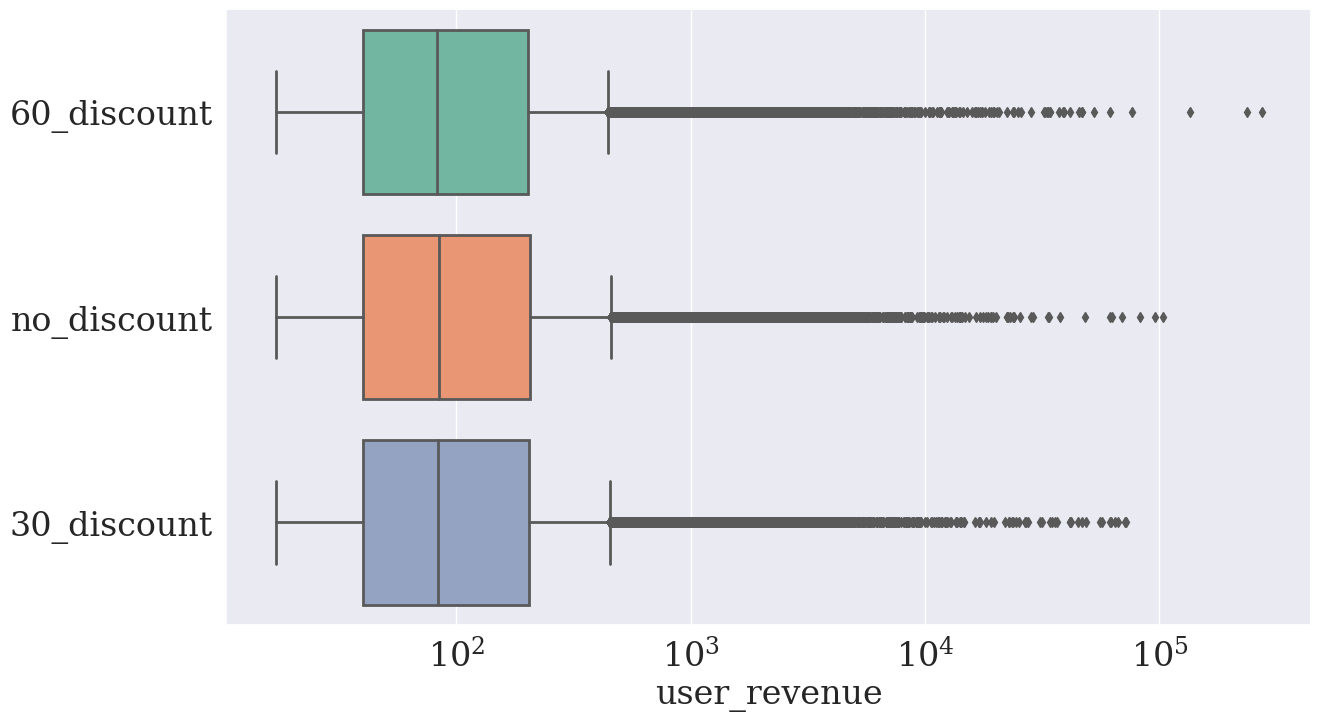

In [98]:
ax = plt.gca()

sns.boxplot(x='user_revenue', y='experiment_group', data=group_info_before, ax=ax)
plt.xscale('log')
plt.ylabel(None)
plt.show()

`no_discount` vs `30_discount`

In [30]:
stat, pval = sps.ttest_ind(
    revenue_no_discount,
    revenue_30_discount,
    equal_var=False,
    alternative='two-sided'
)

print(f'{stat = }, {pval = }')

stat = -0.7550605856355345, pval = 0.45021425406615523


`no_discount` vs `60_discount`

In [31]:
stat, pval = sps.ttest_ind(
    revenue_no_discount,
    revenue_60_discount,
    equal_var=False,
    alternative='two-sided'
)

print(f'{stat = }, {pval = }')

stat = -1.037622209804594, pval = 0.29944881911817856


`30_discount` vs `60_discount`

In [32]:
stat, pval = sps.ttest_ind(
    revenue_30_discount,
    revenue_60_discount,
    equal_var=False,
    alternative='two-sided'
)

print(f'{stat = }, {pval = }')

stat = -0.47894329591892926, pval = 0.631980123610149


**Вывод:**  
Тут порядок: группы однородны

**Распредление айтемов по регионам**

In [33]:
items_no_discount = pd.read_csv(
    'items_distr_no_discount.csv',
    index_col='item_region',
)
items_no_discount.columns = ['no_discount']

items_30_discount = pd.read_csv(
    'items_distr_30_discount.csv',
    index_col='item_region',
)
items_30_discount.columns = ['30_discount']

items_60_discount = pd.read_csv(
    'items_distr_60_discount.csv',
    index_col='item_region',
)
items_60_discount.columns = ['60_discount']

items_by_regions = pd.concat(
    (items_no_discount, items_30_discount, items_60_discount),
    axis=1
)
items_by_regions.dropna(inplace=True)
items_by_regions

,no_discount,30_discount,60_discount
item_region,,,
1,12918.0,13068.0,13455
10,7833.0,7421.0,8013
11,18491.0,17483.0,18003
12,89.0,117.0,153
13,4509.0,3907.0,5197
...,...,...,...
82,25254.0,25691.0,26094
83,3558.0,3999.0,3999
84,248.0,374.0,310


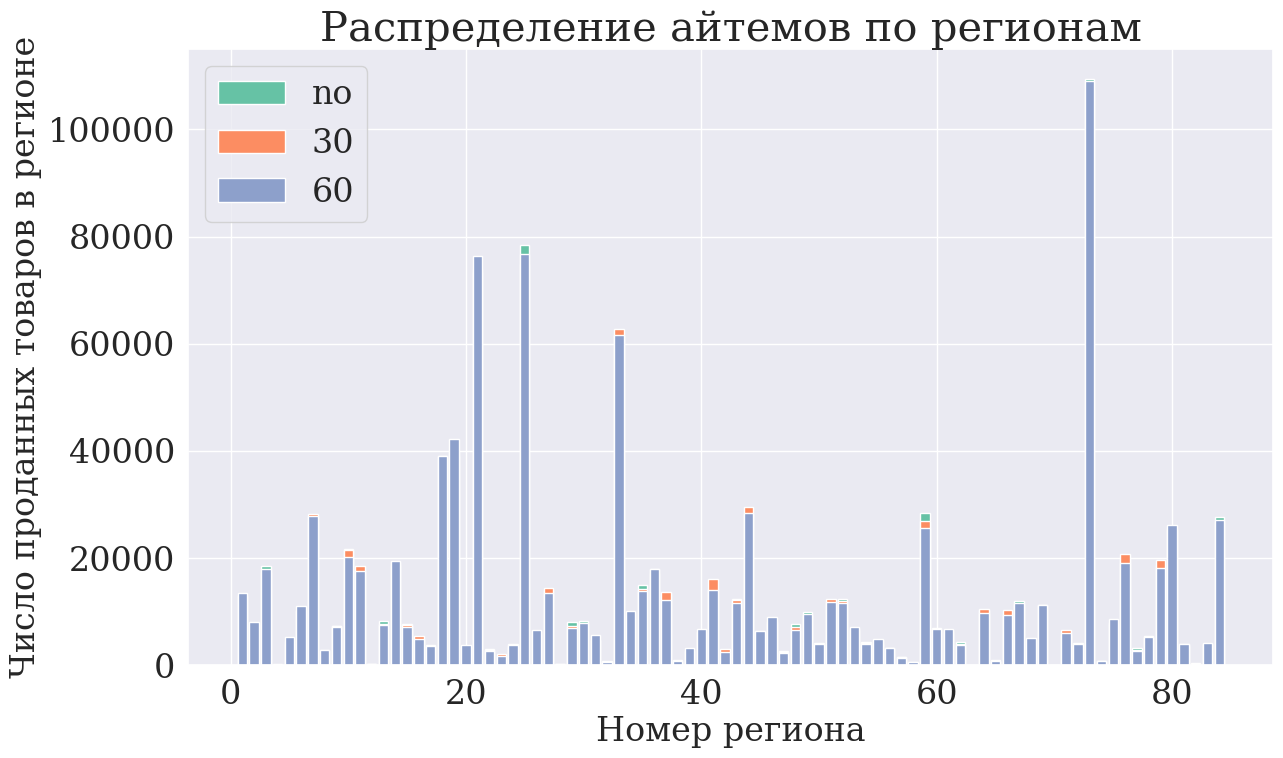

In [106]:
plt.bar(x=range(1, 85), height=items_by_regions.iloc[:, 0], label='no')
plt.bar(x=range(1, 85), height=items_by_regions.iloc[:, 1], label='30')
plt.bar(x=range(1, 85), height=items_by_regions.iloc[:, 2], label='60')

plt.title('Распределение айтемов по регионам')
plt.xlabel('Номер региона')
plt.ylabel('Число проданных товаров в регионе')
plt.legend()
plt.show()

Смотрим на t-тест

In [35]:
items_by_regions.describe()

,no_discount,30_discount,60_discount
count,84.000000,84.000000,84.000000
mean,12599.892857,12526.833333,12550.642857
std,17947.095444,17743.357854,17994.906212
min,45.000000,26.000000,39.000000
25%,3498.500000,3373.750000,3748.750000
50%,7168.500000,7052.000000,6936.500000
75%,13649.750000,13834.000000,13470.250000
max,109482.000000,107409.000000,109071.000000


`no_discount` vs `30_discount`

In [36]:
stat, pval = sps.ttest_ind(
    items_by_regions['no_discount'],
    items_by_regions['30_discount'],
    equal_var=False,
    alternative='two-sided'
)

print(f'{stat = }, {pval = }')

stat = 0.026532143542669, pval = 0.9788647688461711


`no_discount` vs `60_discount`

In [37]:
stat, pval = sps.ttest_ind(
    items_by_regions['no_discount'],
    items_by_regions['60_discount'],
    equal_var=False,
    alternative='two-sided'
)

print(f'{stat = }, {pval = }')

stat = 0.01776062446705492, pval = 0.9858511460025414


`30_discount` vs `60_discount`

In [38]:
stat, pval = sps.ttest_ind(
    items_by_regions['30_discount'],
    items_by_regions['60_discount'],
    equal_var=False,
    alternative='two-sided'
)

print(f'{stat = }, {pval = }')

stat = -0.008634976088747975, pval = 0.9931207421568407


**Вывод:**  
С регионами всё в порядке

## MDE

In [88]:
sample = np.array([0] * int(253000*0.975) + [1] * int(253000*0.025))

for alpha in (0.001, 0.005, 0.01, 0.05):
    for power in (0.5, 0.6, 0.7, 0.8, 0.9):
        print(f'{alpha = }, {power = }')

        effect_size = tt_ind_solve_power(
            nobs1=len(sample),
            alpha=alpha,
            power=power,
            alternative='larger'
        )
        mde = effect_size * sample.std() * 100
        print('MDE =', round(mde, 3), '%')
        print(80*'=')

alpha = 0.001, power = 0.5
MDE = 0.136 %
alpha = 0.001, power = 0.6
MDE = 0.147 %
alpha = 0.001, power = 0.7
MDE = 0.159 %
alpha = 0.001, power = 0.8
MDE = 0.173 %
alpha = 0.001, power = 0.9
MDE = 0.192 %
alpha = 0.005, power = 0.5
MDE = 0.113 %
alpha = 0.005, power = 0.6
MDE = 0.124 %
alpha = 0.005, power = 0.7
MDE = 0.136 %
alpha = 0.005, power = 0.8
MDE = 0.15 %
alpha = 0.005, power = 0.9
MDE = 0.169 %
alpha = 0.01, power = 0.5
MDE = 0.102 %
alpha = 0.01, power = 0.6
MDE = 0.113 %
alpha = 0.01, power = 0.7
MDE = 0.125 %
alpha = 0.01, power = 0.8
MDE = 0.139 %
alpha = 0.01, power = 0.9
MDE = 0.158 %
alpha = 0.05, power = 0.5
MDE = 0.072 %
alpha = 0.05, power = 0.6
MDE = 0.083 %
alpha = 0.05, power = 0.7
MDE = 0.095 %
alpha = 0.05, power = 0.8
MDE = 0.109 %
alpha = 0.05, power = 0.9
MDE = 0.128 %


In [145]:
ALPHA = 0.01
POWER = 0.8

## Ээээээээээээксперименты

![](experiments.jpg)

**Сколько потеряли из-за скидок**

In [40]:
losses_on_discounts = pd.read_csv(
    'losses-on-discounts.csv',
    index_col='experiment_group'
)
losses_on_discounts.apply(lambda x: round(x, -2))

,sum,costs
experiment_group,,
30_discount,73300.0,31400.0
60_discount,66400.0,99600.0
no_discount,51900.0,0.0


**Смотрим на то, сколько людей по каждой из групп стали верифицированными**

In [41]:
conversion_to_verification = pd.read_csv('conversion_to_sign_by_group.csv')
conversion_to_verification.fillna(' ', inplace=True)
conversion_to_verification

,experiment_group,UserType,k_converted,group_size,sign_conversion
0,30_discount,Company,888.0,19537,0.045452
1,30_discount,Private,6254.0,230946,0.027080
2,30_discount,Shop,343.0,3180,0.107862
3,30_discount,,7485.0,253663,0.029508
4,60_discount,Company,910.0,19380,0.046956
5,60_discount,Private,7018.0,230838,0.030402
6,60_discount,Shop,382.0,3223,0.118523
7,60_discount,,8310.0,253441,0.032789
8,no_discount,Company,753.0,19833,0.037967
9,no_discount,Private,5785.0,232506,0.024881


**ДИ для конверсии**

In [196]:
print('No CI:', proportion_confint(6863, 255826, ALPHA))
print('30% CI:', proportion_confint(7485, 253663, ALPHA))
print('60% CI:', proportion_confint(8310, 253441, ALPHA))

No CI: (0.02600397043000687, 0.027649684788774644)
30% CI: (0.028642184062159976, 0.030373123649252407)
60% CI: (0.03187752221336676, 0.03369987055260244)


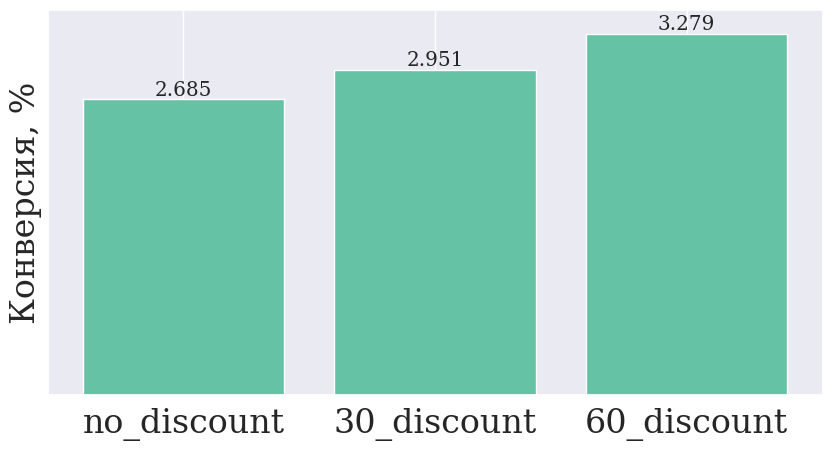

In [123]:
plt.figure(figsize=(10, 5))
ax = plt.gca()
plt.bar(
    x=['no_discount', '30_discount', '60_discount'],
    height=100*np.array([0.026848, 0.029508, 0.032789])
)

for i in ax.containers:
    ax.bar_label(i, fmt=lambda x: round(x, 3))

plt.ylabel('Конверсия, %')
plt.ylim(0, 3.5)
plt.yticks([])
plt.show()

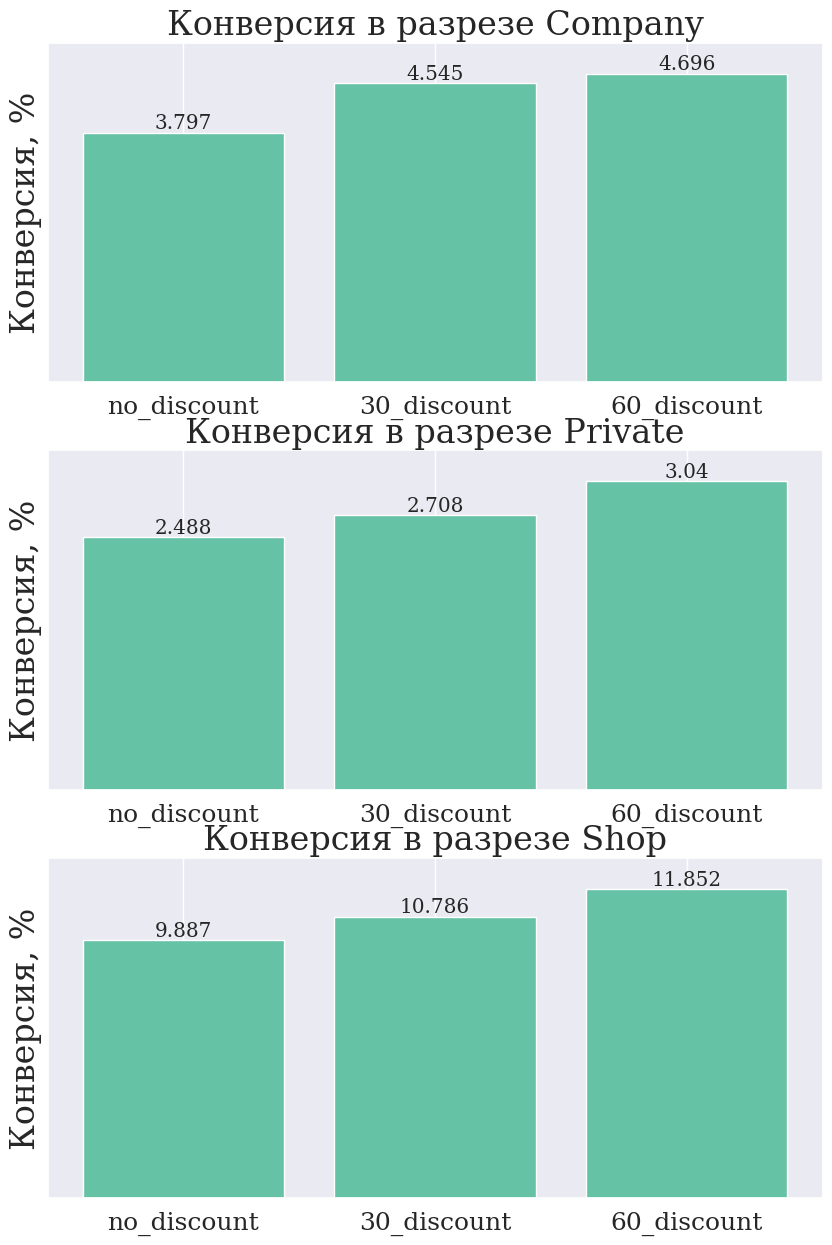

In [143]:
i = 0
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
for usertype in conversion_to_verification['UserType'].unique():
    if usertype == ' ':
        continue
    
    data = conversion_to_verification[conversion_to_verification['UserType'] == usertype]
    data = data[['experiment_group', 'sign_conversion']].sort_values(by='sign_conversion')
    
    axes[i].bar(data['experiment_group'], 100*data['sign_conversion'])
    axes[i].set_title(f'Конверсия в разрезе {usertype}', fontsize=24)
    
    for cont in axes[i].containers:
        axes[i].bar_label(cont, fmt=lambda x: round(x, 3))
    
    axes[i].set_ylim(
        0,
        100*data['sign_conversion'].max()*1.1
    )
    axes[i].set_yticks([])
    axes[i].tick_params(axis='x', which='major', labelsize=18)
    axes[i].set_ylabel('Конверсия, %')
    
    i += 1
    
plt.show()

**Вывод:**  
1. Конверсия `no_discount` = 2.68%, конверсия `30_discount` = 2.95%, конверсия `30_discount` = 3.28% ==> виден рост конверсии с увеличением скидки  
2. Больше всего верифицируются магазины, их конверсия варьируется в районе 10-12%, хуже всего -- частные лица (их подавляющее бол-во -- 91%), их конверсия составляет 2.5 - 3%. У компаний конверсия равна 3.8 - 4.7%  
3. Компании лучше всего отреагировали на скидку в 30% -- конверсия увеличилась на 0.75% (или на 135 компаний), с 30% на 60% разница конверсий гораздо меньше -- всего 0.15% (или на 22 компании).  
4. Частные лица лучше всего отреагировали на скидку в 60% -- дельта с 30% составляет 0.33% (или 750 человек), дельта с 30% на 0% чуть меньше -- 0.22% (или 469 человек)  
5. Скидки в 30% и в 60% вызвали примерно одинаковый прирост -- 0.9% (18 магазинов) и 1.07% (39 магазинов) соответственно

**Two-sampled t-test**

In [44]:
conversion_to_verification

,experiment_group,UserType,k_converted,group_size,sign_conversion
0,30_discount,Company,888.0,19537,0.045452
1,30_discount,Private,6254.0,230946,0.027080
2,30_discount,Shop,343.0,3180,0.107862
3,30_discount,,7485.0,253663,0.029508
4,60_discount,Company,910.0,19380,0.046956
5,60_discount,Private,7018.0,230838,0.030402
6,60_discount,Shop,382.0,3223,0.118523
7,60_discount,,8310.0,253441,0.032789
8,no_discount,Company,753.0,19833,0.037967
9,no_discount,Private,5785.0,232506,0.024881


In [45]:
conversion_no = np.array([1] * 6863 + [0] * (255626 - 6863))
conversion_30 = np.array([1] * 7485 + [0] * (253663 - 7485))
conversion_60 = np.array([1] * 8310 + [0] * (253441 - 8310))

In [46]:
stat, pval = sps.ttest_ind(
    conversion_no,
    conversion_30,
    equal_var=False,
    alternative='less'
)

print(f'no vs 30: {stat = }, {pval = }')

stat, pval = sps.ttest_ind(
    conversion_no,
    conversion_60,
    equal_var=False,
    alternative='less'
)

print(f'no vs 60: {stat = }, {pval = }')

stat, pval = sps.ttest_ind(
    conversion_30,
    conversion_60,
    equal_var=False,
    alternative='less'
)

print(f'30 vs 60: {stat = }, {pval = }')

no vs 30: stat = -5.734985456160714, pval = 4.878789000347953e-09
no vs 60: stat = -12.45982502322921, pval = 6.257451955244146e-36
30 vs 60: stat = -6.725104225523089, pval = 8.782603846343411e-12


In [150]:
cm = CompareMeans(
    DescrStatsW(conversion_30),
    DescrStatsW(conversion_no)
)
ci = cm.tconfint_diff(ALPHA, alternative='two-sided', usevar='unequal')
print('no vs 30 CI:', f'{round(100 * (ci[0] + ci[1]) / 2, 3)}%', '+-', f'{round(100 * (ci[1] - ci[0]) / 2, 3)}%')

cm = CompareMeans(
    DescrStatsW(conversion_60),
    DescrStatsW(conversion_no)
)
ci = cm.tconfint_diff(ALPHA, alternative='two-sided', usevar='unequal')
print('no vs 60 CI:', f'{round(100 * (ci[0] + ci[1]) / 2, 3)}%', '+-', f'{round(100 * (ci[1] - ci[0]) / 2, 3)}%')

cm = CompareMeans(
    DescrStatsW(conversion_60),
    DescrStatsW(conversion_30)
)
ci = cm.tconfint_diff(ALPHA, alternative='two-sided', usevar='unequal')
print('30 vs 60 CI:', f'{round(100 * (ci[0] + ci[1]) / 2, 3)}%', '+-', f'{round(100 * (ci[1] - ci[0]) / 2, 3)}%')


no vs 30 CI: 0.266% +- 0.119%
no vs 60 CI: 0.594% +- 0.123%
30 vs 60 CI: 0.328% +- 0.126%


**Смотрим на экспериментальные данные**

In [50]:
exp_data = pd.read_csv('group_info_during_exp.csv')
exp_data_without_na = exp_data.dropna()
print(exp_data.shape)
exp_data.sample(5)

(63854, 6)


,user_id,experiment_group,UserType,is_verified,user_revenue,exposed_items
31956,368548500053,60_discount,Private,0,NaN,1
5935,376011479,60_discount,Private,0,57.384615,1
1655,79750101,30_discount,Private,0,NaN,1
12791,37709500013,60_discount,Private,0,27.384615,1
44290,569536750031,60_discount,Private,0,40.076923,1


**Число активных во время эксперимента юзеров**

In [51]:
exp_data.groupby(['experiment_group'])['user_id'].count()

experiment_group
30_discount    21328
60_discount    21356
no_discount    21170
Name: user_id, dtype: int64

**Сравниваем кол-во выставленных айтемов по группам**

In [52]:
exp_data.groupby(['experiment_group'])['exposed_items'].describe()

,count,mean,std,min,25%,50%,75%,max
experiment_group,,,,,,,,
30_discount,21328.0,2.454145,10.617091,1.0,1.0,1.0,2.0,844.0
60_discount,21356.0,3.000140,64.538916,1.0,1.0,1.0,2.0,9199.0
no_discount,21170.0,2.542607,10.342288,1.0,1.0,1.0,2.0,809.0


**Агрегированная информация по выручке пользователей**

In [53]:
exp_data.groupby(['experiment_group'])['user_revenue'].sum().apply(lambda x: round(x, -4))

experiment_group
30_discount    1360000.0
60_discount    1580000.0
no_discount    1420000.0
Name: user_revenue, dtype: float64

In [154]:
exp_data.groupby(['experiment_group'])['user_revenue'].describe(percentiles=[.25, .75, .95, .99])

,count,mean,std,min,25%,50%,75%,95%,99%,max
experiment_group,,,,,,,,,,
30_discount,10177.0,134.059329,555.877398,17.0,33.153846,51.461538,102.923077,392.046154,1337.224769,35082.923077
60_discount,10250.0,154.330269,1875.833267,17.0,33.153846,49.730769,102.923077,400.010000,1402.617723,179365.230769
no_discount,10005.0,142.252678,596.894964,17.0,33.153846,49.230769,100.000000,436.630769,1643.178462,39794.384615


In [165]:
discount_no_revenue = exp_data_without_na.loc[
    exp_data_without_na['experiment_group'] == 'no_discount'
]['user_revenue'].values

discount_30_revenue = exp_data_without_na.loc[
    exp_data_without_na['experiment_group'] == '30_discount'
]['user_revenue'].values

discount_60_revenue = exp_data_without_na.loc[
    exp_data_without_na['experiment_group'] == '60_discount'
]['user_revenue'].values

**Визуализация**

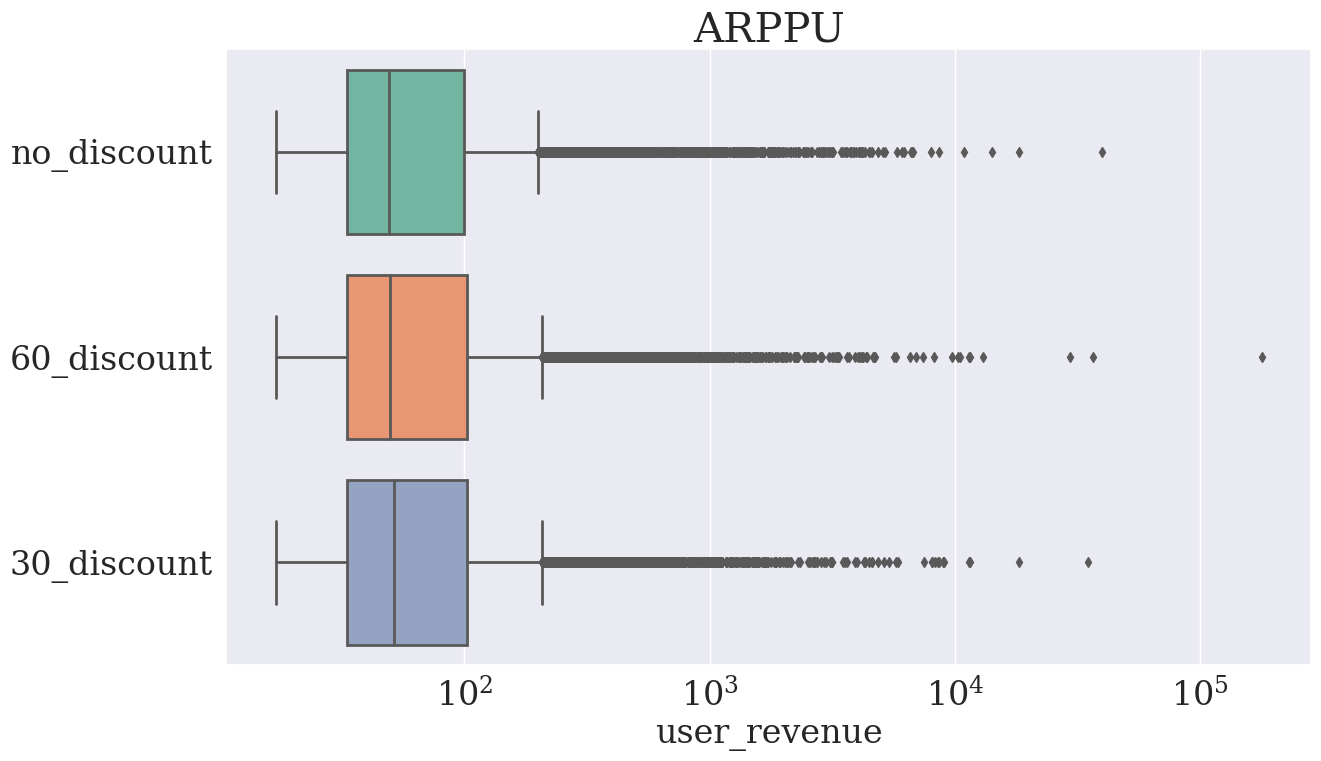

In [153]:
ax = plt.gca()
sns.boxplot(x='user_revenue', y='experiment_group', data=exp_data, ax=ax)
plt.xscale('log')
plt.ylabel(None)
plt.title('ARPPU')
plt.show()

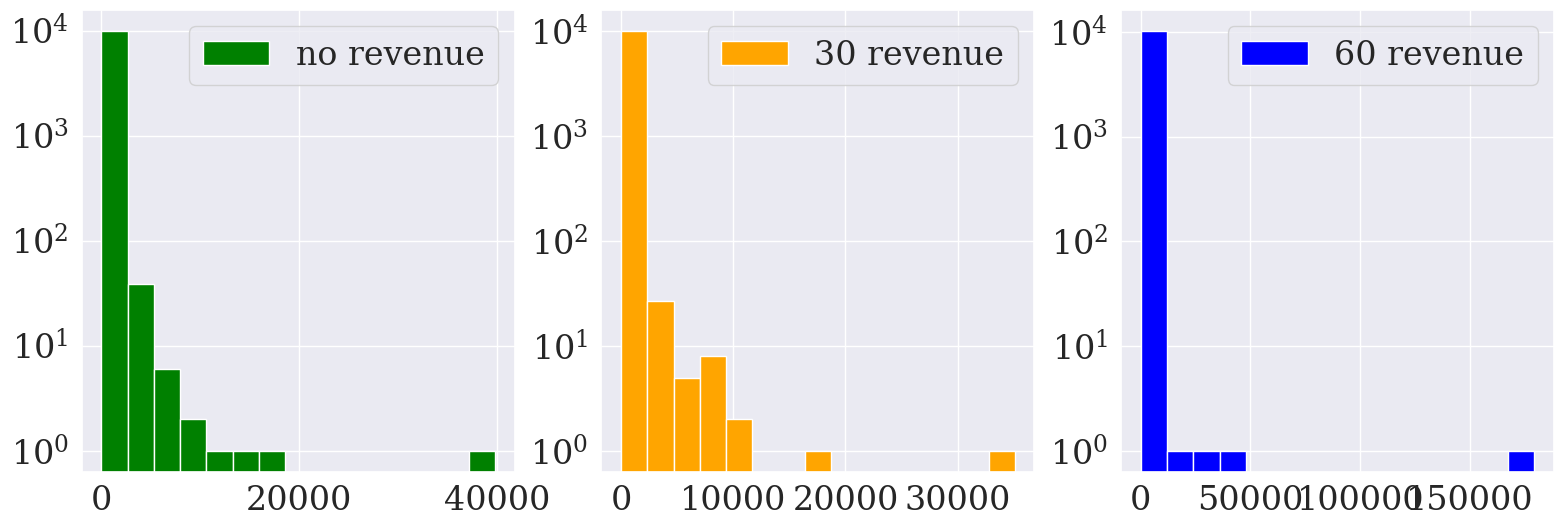

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(19, 6))

axes[0].hist(discount_no_revenue, bins=15, alpha=1, color='green', label='no revenue')
axes[1].hist(discount_30_revenue, bins=15, alpha=1, color='orange', label='30 revenue')
axes[2].hist(discount_60_revenue, bins=15, alpha=1, color='blue', label='60 revenue')

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[2].set_yscale('log')

plt.show()

Применяем t-тест

`no_discount` vs `30_discount`

In [58]:
stat, pval = sps.ttest_ind(
    discount_no_revenue,
    discount_30_revenue,
    equal_var=False,
    alternative='less'
)

print(f'{stat = }, {pval = }')

stat = 1.0087370474813404, pval = 0.8434435260625417


`no_discount` vs `60_discount`

In [59]:
stat, pval = sps.ttest_ind(
    discount_no_revenue,
    discount_60_revenue,
    equal_var=False,
    alternative='less'
)

print(f'{stat = }, {pval = }')

stat = -0.6204633335760261, pval = 0.26748211816902046


`30_discount` vs `60_discount`

In [60]:
stat, pval = sps.ttest_ind(
    discount_30_revenue,
    discount_60_revenue,
    equal_var=False,
    alternative='less'
)

print(f'{stat = }, {pval = }')

stat = -1.0486687155165326, pval = 0.14717582729461073


**Вывод:** 
Предоставление скидок не ухудшило кол-во денег за продвижение

**Outliers impact**

In [178]:
sorted(discount_no_revenue)[-1] / sum(discount_no_revenue) * 100

2.796045592368813

In [179]:
sorted(discount_30_revenue)[-1] / sum(discount_30_revenue) * 100

2.5714551490583077

In [180]:
sorted(discount_60_revenue)[-1] / sum(discount_60_revenue) * 100

11.338700468059198

**Without outliers**

In [173]:
thr = 10000
adj_discount_no_revenue = discount_no_revenue[discount_no_revenue < thr]
adj_discount_30_revenue = discount_30_revenue[discount_30_revenue < thr]
adj_discount_60_revenue = discount_60_revenue[discount_60_revenue < thr]

In [176]:
round(adj_discount_no_revenue.sum(), -3), round(adj_discount_30_revenue.sum(), -3), round(adj_discount_60_revenue.sum(), -3)

(1340000.0, 1288000.0, 1279000.0)

In [174]:
stat, pval = sps.ttest_ind(
    adj_discount_no_revenue,
    adj_discount_30_revenue,
    equal_var=False,
    alternative='less'
)

print(f'no vs 30: {stat = }, {pval = }')

stat, pval = sps.ttest_ind(
    adj_discount_no_revenue,
    adj_discount_60_revenue,
    equal_var=False,
    alternative='less'
)

print(f'no vs 60: {stat = }, {pval = }')

stat, pval = sps.ttest_ind(
    adj_discount_30_revenue,
    adj_discount_60_revenue,
    equal_var=False,
    alternative='less'
)

print(f'30 vs 60: {stat = }, {pval = }')

no vs 30: stat = 1.4407754409725342, pval = 0.9251681647169056
no vs 60: stat = 1.8513723854101776, pval = 0.9679345913999331
30 vs 60: stat = 0.3467317942176495, pval = 0.6356017830414282


**Вывод:** Всё равно стат.значимых изменений нет!

## DAU

In [63]:
dau_data = pd.read_csv('dau.csv')
dau_data['item_creation_time'] = pd.to_datetime(dau_data['item_creation_time'])
dau_data.head()

,item_creation_time,experiment_group,k_active_users
0,2021-09-15,30_discount,389
1,2021-09-15,60_discount,394
2,2021-09-15,no_discount,402
3,2021-09-16,30_discount,362
4,2021-09-16,60_discount,378


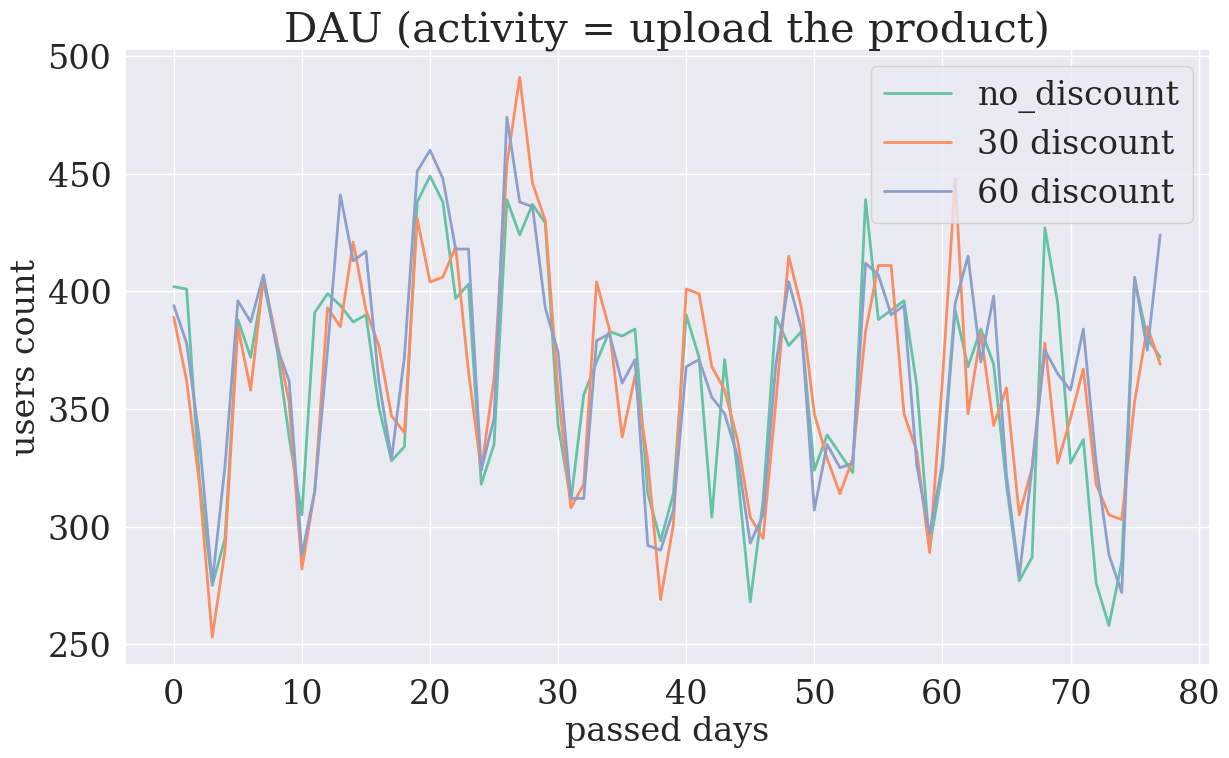

In [79]:
dau_no = dau_data[dau_data.experiment_group == 'no_discount'].reset_index()
dau_30 = dau_data[dau_data.experiment_group == '30_discount'].reset_index()
dau_60 = dau_data[dau_data.experiment_group == '60_discount'].reset_index()

plt.plot(dau_no.k_active_users, label='no_discount')
plt.plot(dau_30.k_active_users, label='30 discount')
plt.plot(dau_60.k_active_users, label='60 discount')

plt.xlabel('passed days')
plt.ylabel('users count')
plt.title('DAU (activity = upload the product)')
plt.legend()
plt.show()

In [181]:
def simple_relative_ttest_CI(test: np.ndarray, control: np.ndarray, alpha: float = 0.05) -> tuple:
    """
    Построение относительного доверительного интервала в случае выборок одинакового размера: ET/EC - 1
    """
    assert len(test) == len(control)
    left_bound = 0
    right_bound = 0
    
    n = len(test)
    coef_c = np.mean(test) / np.mean(control)
    coef_d = 1 / np.mean(control)
    
    modified_sample = test - coef_c * control
    ttest_res = sps.ttest_1samp(modified_sample, 0)
    ci = ttest_res.confidence_interval(1-alpha)
    
    left_bound = coef_c + coef_d * ci[0]
    right_bound = coef_c + coef_d * ci[1]
    
    return left_bound, right_bound

$$\dfrac{DAU_{30}}{DAU_{no}} \in (0.976, 1.026) $$

$$\dfrac{DAU_{60}}{DAU_{no}} \in (0.991, 1.032) $$

$$\dfrac{DAU_{60}}{DAU_{30}} \in (0.988, 1.033) $$

In [187]:
print('no DAU / 30 DAU CI:', simple_relative_ttest_CI(dau_30.k_active_users, dau_no.k_active_users, 0.01))
print('no DAU / 60 DAU CI:', simple_relative_ttest_CI(dau_60.k_active_users, dau_no.k_active_users, 0.01))
print('30 DAU / 60 DAU CI:', simple_relative_ttest_CI(dau_60.k_active_users, dau_30.k_active_users, 0.01))

no DAU / 30 DAU CI: (0.9758808170842713, 1.026257381839502)
no DAU / 60 DAU CI: (0.9910296198566817, 1.0324192950073645)
30 DAU / 60 DAU CI: (0.9882521599148382, 1.0330357970820647)


## Вывод

Берём 3ий вариант, что со скидкой в 60%